# Description

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this dataset from Kaggle competition challenges you to predict the final price of each home.

# Requirements

- Train, validate (using a dedicated validation set) and submit a linear regression model.
- Train, validate (using a dedicated validation set) and submit a random forest regressor model.
- Achieve a score better than 0.14 on the public leaderboard.

# Evaluation criteria

- Public leaderboard score
- How simple is the model
- Code quality

# Data cleaning

In [240]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 20)
import seaborn as sns
sns.set_theme()
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split

In [241]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

In [242]:
#msno.bar(train_data, labels=True, fontsize=12);

In [243]:
#msno.bar(test_data, labels=True, fontsize=12);

In the very beginning I have decided entirely drop Alley, PoolQC, Fence and MiscFeature features because majority of values are missing.

In [244]:
features_to_drop = ["Id", "Alley", "PoolQC", "Fence", "MiscFeature"]
cleaned_train_data = train_data.drop(columns=features_to_drop)
cleaned_test_data = test_data.drop(columns=features_to_drop)

Assuming that majority of lot areas in one neighborhood are more or less similar, I have filled missing values in LotFrontage column by most frequent value of particular neighborhood. 

In [245]:
fill_mode = lambda x: x.value_counts().index[0]

cleaned_train_data["LotFrontage"] = cleaned_train_data["LotFrontage"].fillna(cleaned_train_data.groupby("Neighborhood")["LotFrontage"].transform(fill_mode))
cleaned_test_data["LotFrontage"] = cleaned_test_data["LotFrontage"].fillna(cleaned_test_data.groupby("Neighborhood")["LotFrontage"].transform(fill_mode))

In [246]:
print("Most frequent value in MasVnrType column:", cleaned_train_data["MasVnrType"].mode()[0])
print("Most frequent value in MasVnrAre column:", cleaned_train_data["MasVnrArea"].mode()[0])

Most frequent value in MasVnrType column: None
Most frequent value in MasVnrAre column: 0.0


In [247]:
print("Number of most frequent value in MasVnrType column:", cleaned_train_data[cleaned_train_data["MasVnrType"] == "None"].shape[0])
print("Number of most frequent value in MasVnrAre column:", cleaned_train_data[cleaned_train_data["MasVnrArea"] == 0.0].shape[0])

Number of most frequent value in MasVnrType column: 864
Number of most frequent value in MasVnrAre column: 861


More than a half of values in both MasVnrType and MasVnrAre columns are None or 0.0 respectively. Also I made a technical assumption that masonry type depends on RoofStyle, RoofMatl and Exterior1st or vice versa. So the most frequent values of latter features, which also are values of coresponding rows with missing values in MasVnrType and MasVnrAre columns, are None and 0.0.

In [248]:
cleaned_train_data["MasVnrType"] = cleaned_train_data["MasVnrType"].fillna("None")
cleaned_train_data["MasVnrArea"] = cleaned_train_data["MasVnrArea"].fillna(0.0)

cleaned_test_data["MasVnrType"] = cleaned_test_data["MasVnrType"].fillna("None")
cleaned_test_data["MasVnrArea"] = cleaned_test_data["MasVnrArea"].fillna(0.0)

About 40 values are missing which are related to the features of basement and according to data description file this means that the house has no basement, so I have changed these NA values to None.

In [249]:
basement_features = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]

for feature in basement_features:
    cleaned_train_data[feature] = cleaned_train_data[feature].fillna("None")
    cleaned_test_data[feature] = cleaned_test_data[feature].fillna("None")

NA value in the FireplaceQu column means that house has no fireplace so I have changed these NA values to None.

In [250]:
cleaned_train_data["FireplaceQu"] = cleaned_train_data["FireplaceQu"].fillna("None")
cleaned_test_data["FireplaceQu"] = cleaned_test_data["FireplaceQu"].fillna("None")

NA values in features which are related to garage also corresponds that house has no garage, so I have changed these NA values to None.

In [251]:
garage_features = ["GarageType", "GarageYrBlt", "GarageFinish", "GarageQual", "GarageCond"]

for feature in garage_features:
    cleaned_train_data[feature] = cleaned_train_data[feature].fillna("None")
    cleaned_test_data[feature] = cleaned_test_data[feature].fillna("None")

In [252]:
#msno.bar(cleaned_train_data, labels=True, fontsize=12);

## Missing values of test set 

In [253]:
#msno.bar(cleaned_test_data, labels=True, fontsize=12);

Some columns in test set are missing just one or two values, so I have simply filled these missing values with most frequent values in those columns.

In [254]:
missing_test_features = [column for column in cleaned_test_data if cleaned_test_data[column].isna().any() == True]

In [255]:
for feature in missing_test_features:
    cleaned_test_data[feature] = cleaned_test_data[feature].fillna(cleaned_test_data[feature].value_counts().index[0])

In [256]:
#msno.bar(cleaned_test_data, labels=True, fontsize=12);

# Exploratory data analysis

In [257]:
cleaned_train_data["GrLivArea"].describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

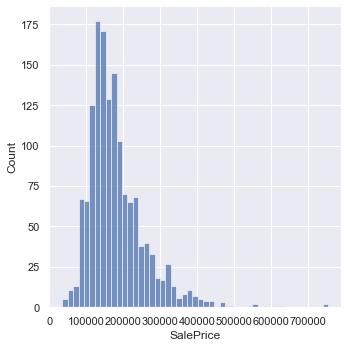

In [258]:
sns.displot(data=cleaned_train_data, x="SalePrice");

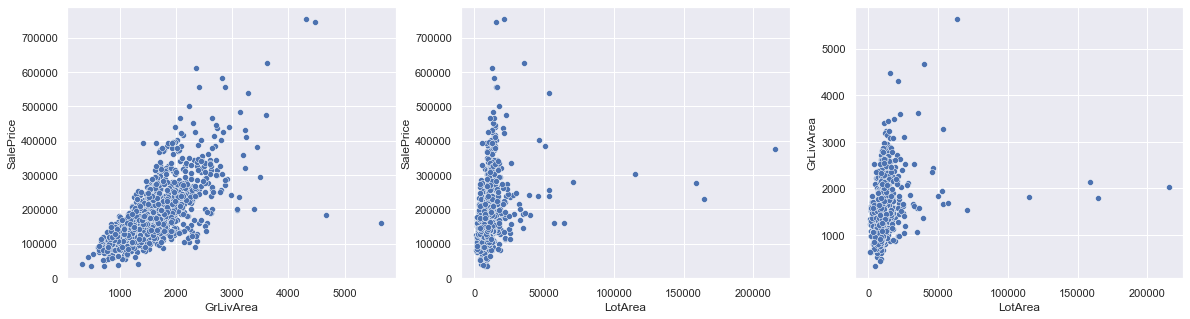

In [259]:
fig, axes = plt.subplots(ncols=3, figsize=(20,5))
sns.scatterplot(ax=axes[0], data=cleaned_train_data, x="GrLivArea", y="SalePrice")
sns.scatterplot(ax=axes[1], data=cleaned_train_data, x="LotArea", y="SalePrice")
sns.scatterplot(ax=axes[2], data=cleaned_train_data, x="LotArea", y="GrLivArea");

In GrLivArea vs. SalePrice graph are two not logic values where price is very low compared to GrLivArea value. Also in LotArea vs. SalePrice graph are obvious outliers above 100000 LotArea values. So I have decided to remove aforementioned values and after submission linear regression score was almost twice better but random forest score was slightly worse, but it is worth to leave this change due to improvement on linear regression model.

In [213]:
cleaned_train_data.drop(cleaned_train_data[(cleaned_train_data["GrLivArea"] > 4000) & (cleaned_train_data["SalePrice"] < 200000)].index, inplace=True)

In [214]:
cleaned_train_data.drop(cleaned_train_data[cleaned_train_data["LotArea"] > 100000].index, inplace=True)

In [215]:
cleaned_train_data.shape

(1454, 76)

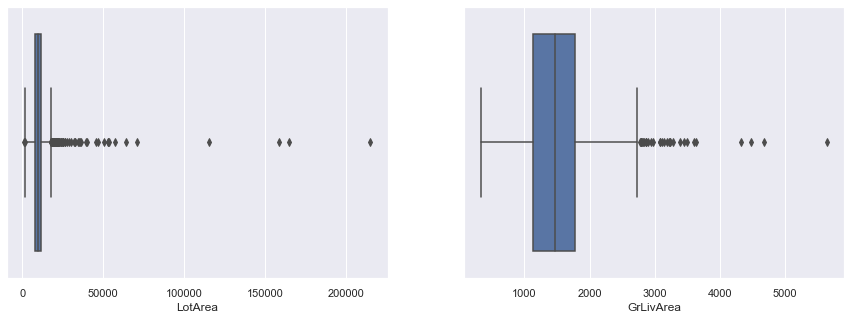

In [260]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
sns.boxplot(ax=axes[0], x=cleaned_train_data["LotArea"])
sns.boxplot(ax=axes[1], x=cleaned_train_data["GrLivArea"]);

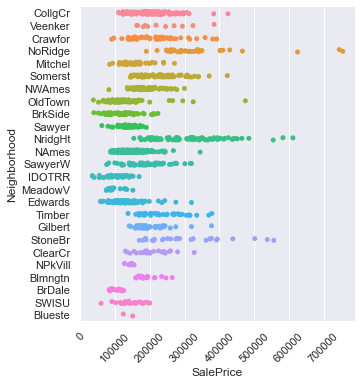

In [217]:
sns.catplot(data=cleaned_train_data, x="SalePrice", y="Neighborhood")
plt.xticks(rotation=45);

# Feature engineering

## Feature encoding

### Mapping

Some categorical features have clear order, therefore I have decided to map that values with numbers in sequence. 

In [218]:
train_encoded_data = cleaned_train_data.copy()
test_encoded_data = cleaned_test_data.copy()

In [219]:
quality_mapping = {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
quality_features = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "HeatingQC"]

for feature in quality_features:
    train_encoded_data[feature] = train_encoded_data[feature].map(quality_mapping)
    test_encoded_data[feature] = test_encoded_data[feature].map(quality_mapping)

In [220]:
basement_rating_mapping = {"None": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
basement_rating_features = ["BsmtFinType1", "BsmtFinType2"]

for feature in basement_rating_features:
    train_encoded_data[feature] = train_encoded_data[feature].map(basement_rating_mapping)
    test_encoded_data[feature] = test_encoded_data[feature].map(basement_rating_mapping)

In [221]:
utilities_mapping = {"ELO": 1, "NoSeWa": 2, "NoSewr": 3, "AllPub": 4}
train_encoded_data["Utilities"] = train_encoded_data["Utilities"].map(utilities_mapping)
test_encoded_data["Utilities"] = test_encoded_data["Utilities"].map(utilities_mapping)

In [222]:
central_air_mapping = {"N": 0, "Y": 1}
train_encoded_data["CentralAir"] = train_encoded_data["CentralAir"].map(central_air_mapping)
test_encoded_data["CentralAir"] = test_encoded_data["CentralAir"].map(central_air_mapping)

In [223]:
garage_finish_mapping = {"None": 0, "Unf": 1, "RFn": 2, "Fin": 3}
train_encoded_data["GarageFinish"] = train_encoded_data["GarageFinish"].map(garage_finish_mapping)
test_encoded_data["GarageFinish"] = test_encoded_data["GarageFinish"].map(garage_finish_mapping)

In [224]:
train_encoded_data["GarageYrBlt"] = train_encoded_data["GarageYrBlt"].replace("None", 0)
test_encoded_data["GarageYrBlt"] = test_encoded_data["GarageYrBlt"].replace("None", 0)

The feature GarageYrBlt itself is not so usefull for modelling because it shouldn't be treated like mere number and it's better to use duration metric.

In [225]:
train_encoded_data["GarageAge"] = train_encoded_data["YrSold"] - train_encoded_data["GarageYrBlt"].astype("int64")
test_encoded_data["GarageAge"] = test_encoded_data["YrSold"] - test_encoded_data["GarageYrBlt"].astype("int64")

In [226]:
train_encoded_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,GarageAge
0,60,RL,65.0,8450,Pave,Reg,Lvl,4,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4,3,No,6,706,1,0,150,856,GasA,5,1,SBrkr,856,854,0,1710,1,0,2,1,3,1,4,8,Typ,0,0,Attchd,2003.0,2,2,548,3,3,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,5
1,20,RL,80.0,9600,Pave,Reg,Lvl,4,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4,3,Gd,5,978,1,0,284,1262,GasA,5,1,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,Typ,1,3,Attchd,1976.0,2,2,460,3,3,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,31
2,60,RL,68.0,11250,Pave,IR1,Lvl,4,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4,3,Mn,6,486,1,0,434,920,GasA,5,1,SBrkr,920,866,0,1786,1,0,2,1,3,1,4,6,Typ,1,3,Attchd,2001.0,2,2,608,3,3,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,7
3,70,RL,60.0,9550,Pave,IR1,Lvl,4,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3,4,No,5,216,1,0,540,756,GasA,4,1,SBrkr,961,756,0,1717,1,0,1,0,3,1,4,7,Typ,1,4,Detchd,1998.0,1,3,642,3,3,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,8
4,60,RL,84.0,14260,Pave,IR1,Lvl,4,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4,3,Av,6,655,1,0,490,1145,GasA,5,1,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,4,9,Typ,1,3,Attchd,2000.0,2,3,836,3,3,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,8


In [227]:
testing_df = train_encoded_data.copy()

### One-hot encoding

In [228]:
categorical_train_features = [column for column in train_encoded_data if train_encoded_data[column].dtypes == "object"]
categorical_test_features = [column for column in test_encoded_data if test_encoded_data[column].dtypes == "object"]

train_oh_encoded_data = pd.get_dummies(train_encoded_data, columns=categorical_train_features)
test_oh_encoded_data = pd.get_dummies(test_encoded_data, columns=categorical_test_features)

In [229]:
print("Train set columns:", train_oh_encoded_data.shape[1])
print("Test set columns:", test_oh_encoded_data.shape[1])

Train set columns: 232
Test set columns: 218


# Modelling

Kaggle submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price, so the corresponding column of train set used to evaluation shuold be in the logarithmic scale too.

In [230]:
# Create sets for cross validation.
train_evaluation_data = train_oh_encoded_data.copy()
train_evaluation_data["SalePrice"] = np.log(train_evaluation_data["SalePrice"])

Test set has fewer columns after one-hot encoding due to unequal number of unique values in categorical features. To tackle this problem I have used pandas align function.  

In [231]:
final_train_data, final_test_data = train_oh_encoded_data.align(test_oh_encoded_data, join='inner', axis=1)

print("Final train set columns:", final_train_data.shape[1])
print("Final test set columns:", final_test_data.shape[1])

Final train set columns: 218
Final test set columns: 218


In [232]:
target = "SalePrice"
features = [column for column in final_train_data]

X_eval = train_evaluation_data[features]
y_eval = train_evaluation_data[target]

X_train = final_train_data[features]
y_train = train_oh_encoded_data[target]

## Linear regression

In [233]:
linear_regression = LinearRegression()

### Linear regression with cross validation

In [234]:
# Evaluation
linear_scores = cross_val_score(linear_regression, X_eval, y_eval, scoring="neg_root_mean_squared_error")
print("Linear regression RMSE:", linear_scores.mean())

Linear regression RMSE: -0.12433770090397492


In [235]:
linear_regression.fit(X_train, y_train)
linear_predictions = linear_regression.predict(final_test_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": linear_predictions})
output.to_csv("submissions/linear_predictions.csv", index=False)

## Random forest regressor

In [236]:
random_forest = RandomForestRegressor()

### Random forest with cross validation

In [237]:
# Evaluation
random_forest_scores = cross_val_score(random_forest, X_eval, y_eval, scoring="neg_root_mean_squared_error")
print("Random forest regressor RMSE:", random_forest_scores.mean())

Random forest regressor RMSE: -0.13652152570914386


In [238]:
random_forest.fit(X_train, y_train)
random_forest_predictions = random_forest.predict(final_test_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": random_forest_predictions})
output.to_csv("submissions/random_forest_predictions.csv", index=False)

# Notes

Baseline linear regression model score in notebook: 0.16283
Baseline linear regression model score in Kaggle: 0.34524

Baseline random forest regressor model score in notebook: 0.14265
Baseline random forest regressor model score in Kaggle: 0.14420

Why it is such a big difference of baseline linear regressions model score?

# Fails

### Things which didn't have any improvements to final score.

- Data shuffling - shuffling data before cross validation doesn't improve score.
- train_test_split - score is slightly worse than with cross validation.
- Squared root - squared root from features which metrics are squared showed better result with linear regression but this model doesn't work well and Kaggle submission score is very low.